#Necessary imports

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
!pip install -q lightly

In [31]:
import numpy as np
import pandas as pd
import copy
import torch
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from torch import nn
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torchvision

from torch import nn
from torchvision import transforms

from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform

from lightly.data import LightlyDataset
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [32]:
def reproducibility(SEED):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)

reproducibility(42)

#Define model

In [33]:
class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

#Data (cifar10 or cifar100)

In [34]:
def get_input_stats(dataset):
    if dataset == 'cifar_100':
        data_mean, data_std = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    elif dataset == 'cifar_10':
        data_mean, data_std = (0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)

    return data_mean, data_std

In [35]:
resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimCLR(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Files already downloaded and verified


In [57]:
transform = SimCLRTransform(input_size=32, gaussian_blur=0.0)
cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", download=True)

data_mean, data_std = get_input_stats('cifar_10')
normalize_dict = {'mean': data_mean, 'std': data_std}

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

Files already downloaded and verified


#Optimizer and Scheduler

In [36]:
criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.85)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr=0.01, max_lr=0.1)
n_epochs, max_norm = 20, 0.1

#KNN and dataloaders for evaluation

In [37]:
from torchvision import transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

BATCH_SIZE = 128

test_transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ])

def get_cifar10_dataloader(batch_size, train=True, transform=test_transform):
    dataset = CIFAR10(root="./", train=train, transform=transform, download=True)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, drop_last=True)


loader_train_plain = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=True, transform=test_transform)
loader_test = get_cifar10_dataloader(batch_size=BATCH_SIZE, train=False, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [38]:
class KNN():
    def __init__(self, model, k, device):
        super(KNN, self).__init__()
        self.k = k
        self.device = device
        self.model = model.to(device)
        self.model.eval()

    def extract_features(self, loader):
        x_lst = []
        features = []
        label_lst = []

        with torch.no_grad():
            for input_tensor, label in loader:
                h = self.model(input_tensor.to(self.device))
                features.append(h)
                x_lst.append(input_tensor)
                label_lst.append(label)

            x_total = torch.stack(x_lst)
            h_total = torch.stack(features)
            label_total = torch.stack(label_lst)

            return x_total, h_total, label_total

    def knn(self, features, labels, k=1):
        """
        Evaluating knn accuracy in feature space.
        Calculates only top-1 accuracy (returns 0 for top-5)
        Args:
            features: [... , dataset_size, feat_dim]
            labels: [... , dataset_size]
            k: nearest neighbours
        Returns: train accuracy, or train and test acc
        """
        feature_dim = features.shape[-1]
        with torch.no_grad():
            features_np = features.cpu().view(-1, feature_dim).numpy()
            labels_np = labels.cpu().view(-1).numpy()
            # fit
            self.cls = KNeighborsClassifier(k, metric='cosine').fit(features_np, labels_np)
            acc = self.eval(features, labels)

        return acc

    def eval(self, features, labels):
      feature_dim = features.shape[-1]
      features = features.cpu().view(-1, feature_dim).numpy()
      labels = labels.cpu().view(-1).numpy()
      acc = 100 * np.mean(cross_val_score(self.cls, features, labels))
      return acc

    def _find_best_indices(self, h_query, h_ref):
        h_query = h_query / h_query.norm(dim=1).view(-1, 1)
        h_ref = h_ref / h_ref.norm(dim=1).view(-1, 1)
        scores = torch.matmul(h_query, h_ref.t())  # [query_bs, ref_bs]
        score, indices = scores.topk(1, dim=1)  # select top k best
        return score, indices

    def fit(self, train_loader, test_loader=None):
        with torch.no_grad():
            x_train, h_train, l_train = self.extract_features(train_loader)
            train_acc = self.knn(h_train, l_train, k=self.k)

            if test_loader is not None:
                x_test, h_test, l_test = self.extract_features(test_loader)
                test_acc = self.eval(h_test, l_test)
                return train_acc, test_acc

#Make directory for saving models

In [39]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [58]:
best_val_acc = 0

print("Starting Training")
for epoch in tqdm(range(n_epochs)):
    total_loss = 0
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"\n epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    ssl_evaluator = KNN(model=model, k=1, device='cuda')
    train_acc, val_acc = ssl_evaluator.fit(loader_train_plain, loader_test)
    if val_acc > best_val_acc:
        torch.save(model.state_dict(),f'models/SimCLR_model_acc{val_acc:.2f}.pt')
        best_val_acc = val_acc
    print(f'\n Train Accuracy:{train_acc:.1f}%',f' Val Accuracy:{val_acc:.1f}%')

Starting Training


  0%|          | 0/20 [00:00<?, ?it/s]


 epoch: 00, loss: 4.58302


  5%|▌         | 1/20 [02:22<45:02, 142.25s/it]


 Train Accuracy:34.9%  Val Accuracy:33.7%

 epoch: 01, loss: 4.57654


 10%|█         | 2/20 [04:45<42:48, 142.70s/it]


 Train Accuracy:35.2%  Val Accuracy:32.8%

 epoch: 02, loss: 4.56413


 15%|█▌        | 3/20 [07:08<40:28, 142.83s/it]


 Train Accuracy:35.1%  Val Accuracy:32.8%

 epoch: 03, loss: 4.56510


 20%|██        | 4/20 [09:31<38:07, 142.98s/it]


 Train Accuracy:35.6%  Val Accuracy:33.6%

 epoch: 04, loss: 4.55901


 25%|██▌       | 5/20 [11:54<35:47, 143.16s/it]


 Train Accuracy:35.9%  Val Accuracy:34.1%

 epoch: 05, loss: 4.54934


 30%|███       | 6/20 [14:18<33:24, 143.21s/it]


 Train Accuracy:36.2%  Val Accuracy:34.1%

 epoch: 06, loss: 4.54992


 35%|███▌      | 7/20 [16:41<31:03, 143.31s/it]


 Train Accuracy:36.1%  Val Accuracy:34.6%

 epoch: 07, loss: 4.54571


 40%|████      | 8/20 [19:05<28:40, 143.36s/it]


 Train Accuracy:36.6%  Val Accuracy:34.6%

 epoch: 08, loss: 4.53393


 45%|████▌     | 9/20 [21:29<26:20, 143.66s/it]


 Train Accuracy:37.0%  Val Accuracy:35.1%

 epoch: 09, loss: 4.52947


 50%|█████     | 10/20 [23:52<23:53, 143.32s/it]


 Train Accuracy:37.2%  Val Accuracy:34.6%

 epoch: 10, loss: 4.53032


 55%|█████▌    | 11/20 [26:16<21:31, 143.55s/it]


 Train Accuracy:37.5%  Val Accuracy:36.0%

 epoch: 11, loss: 4.52910


 60%|██████    | 12/20 [28:41<19:11, 143.96s/it]


 Train Accuracy:37.8%  Val Accuracy:35.6%

 epoch: 12, loss: 4.52274


 65%|██████▌   | 13/20 [31:07<16:53, 144.84s/it]


 Train Accuracy:38.1%  Val Accuracy:35.6%

 epoch: 13, loss: 4.51651


 70%|███████   | 14/20 [33:33<14:30, 145.11s/it]


 Train Accuracy:38.3%  Val Accuracy:36.0%

 epoch: 14, loss: 4.51682


 75%|███████▌  | 15/20 [36:03<12:12, 146.46s/it]


 Train Accuracy:38.3%  Val Accuracy:36.0%

 epoch: 15, loss: 4.50645


 80%|████████  | 16/20 [38:28<09:43, 145.97s/it]


 Train Accuracy:38.7%  Val Accuracy:36.4%

 epoch: 16, loss: 4.49791


 85%|████████▌ | 17/20 [40:53<07:17, 145.77s/it]


 Train Accuracy:38.5%  Val Accuracy:36.5%

 epoch: 17, loss: 4.49961


 90%|█████████ | 18/20 [43:16<04:50, 145.10s/it]


 Train Accuracy:38.9%  Val Accuracy:36.8%

 epoch: 18, loss: 4.49110


 95%|█████████▌| 19/20 [45:41<02:24, 144.80s/it]


 Train Accuracy:39.7%  Val Accuracy:38.2%

 epoch: 19, loss: 4.49011


100%|██████████| 20/20 [48:06<00:00, 144.33s/it]


 Train Accuracy:39.5%  Val Accuracy:37.1%


#Load best model we have got

In [59]:
model.load_state_dict(torch.load('models/SimCLR_model_acc38.23.pt'))

<All keys matched successfully>

#Visual evaluation

In [60]:
transform_clean = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std),
])

dataset = LightlyDataset.from_torch_dataset(cifar10, transform=transform_clean)

dataloader_test = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=False, drop_last=True, num_workers=1,
)

In [61]:
def generate_embeddings(model, dataloader):
    embeddings, filenames, labels = [], [], []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(DEVICE)
            emb = model(img).flatten(start_dim=1).cpu()
            embeddings.append(emb)
            filenames.extend(fnames)
            labels.extend(label)
            break

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames, labels

# backbone.eval()
backbone = model.backbone
backbone.eval()
embeddings, filenames, labels = generate_embeddings(backbone, dataloader_test)

In [62]:
def class_name(index):
    return cifar10.classes[index.item()]

In [63]:
path_to_data = '/content/datasets/' + 'cifar10'

def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
#     img = Image.open(filename)
#     return np.asarray(img)
    img = dataset[int(filename)][0]
    return np.clip(img.permute(1, 2, 0).numpy(),0,1)

def plot_knn_examples(embeddings, filenames, labels, n_neighbors=5, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples; we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get n random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    fig,axes = plt.subplots(num_examples,n_neighbors,figsize=(40,40),constrained_layout=True)
    for example_index,idx in tqdm(enumerate(samples_idx)):
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            image = get_image_as_np_array(filenames[neighbor_idx])
            axes[example_index,plot_x_offset].imshow(image)
            axes[example_index,plot_x_offset].set_title(class_name(labels[neighbor_idx]) + ' ' + f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")
    plt.savefig('knn_examples.png')

5it [00:00, 79.28it/s]


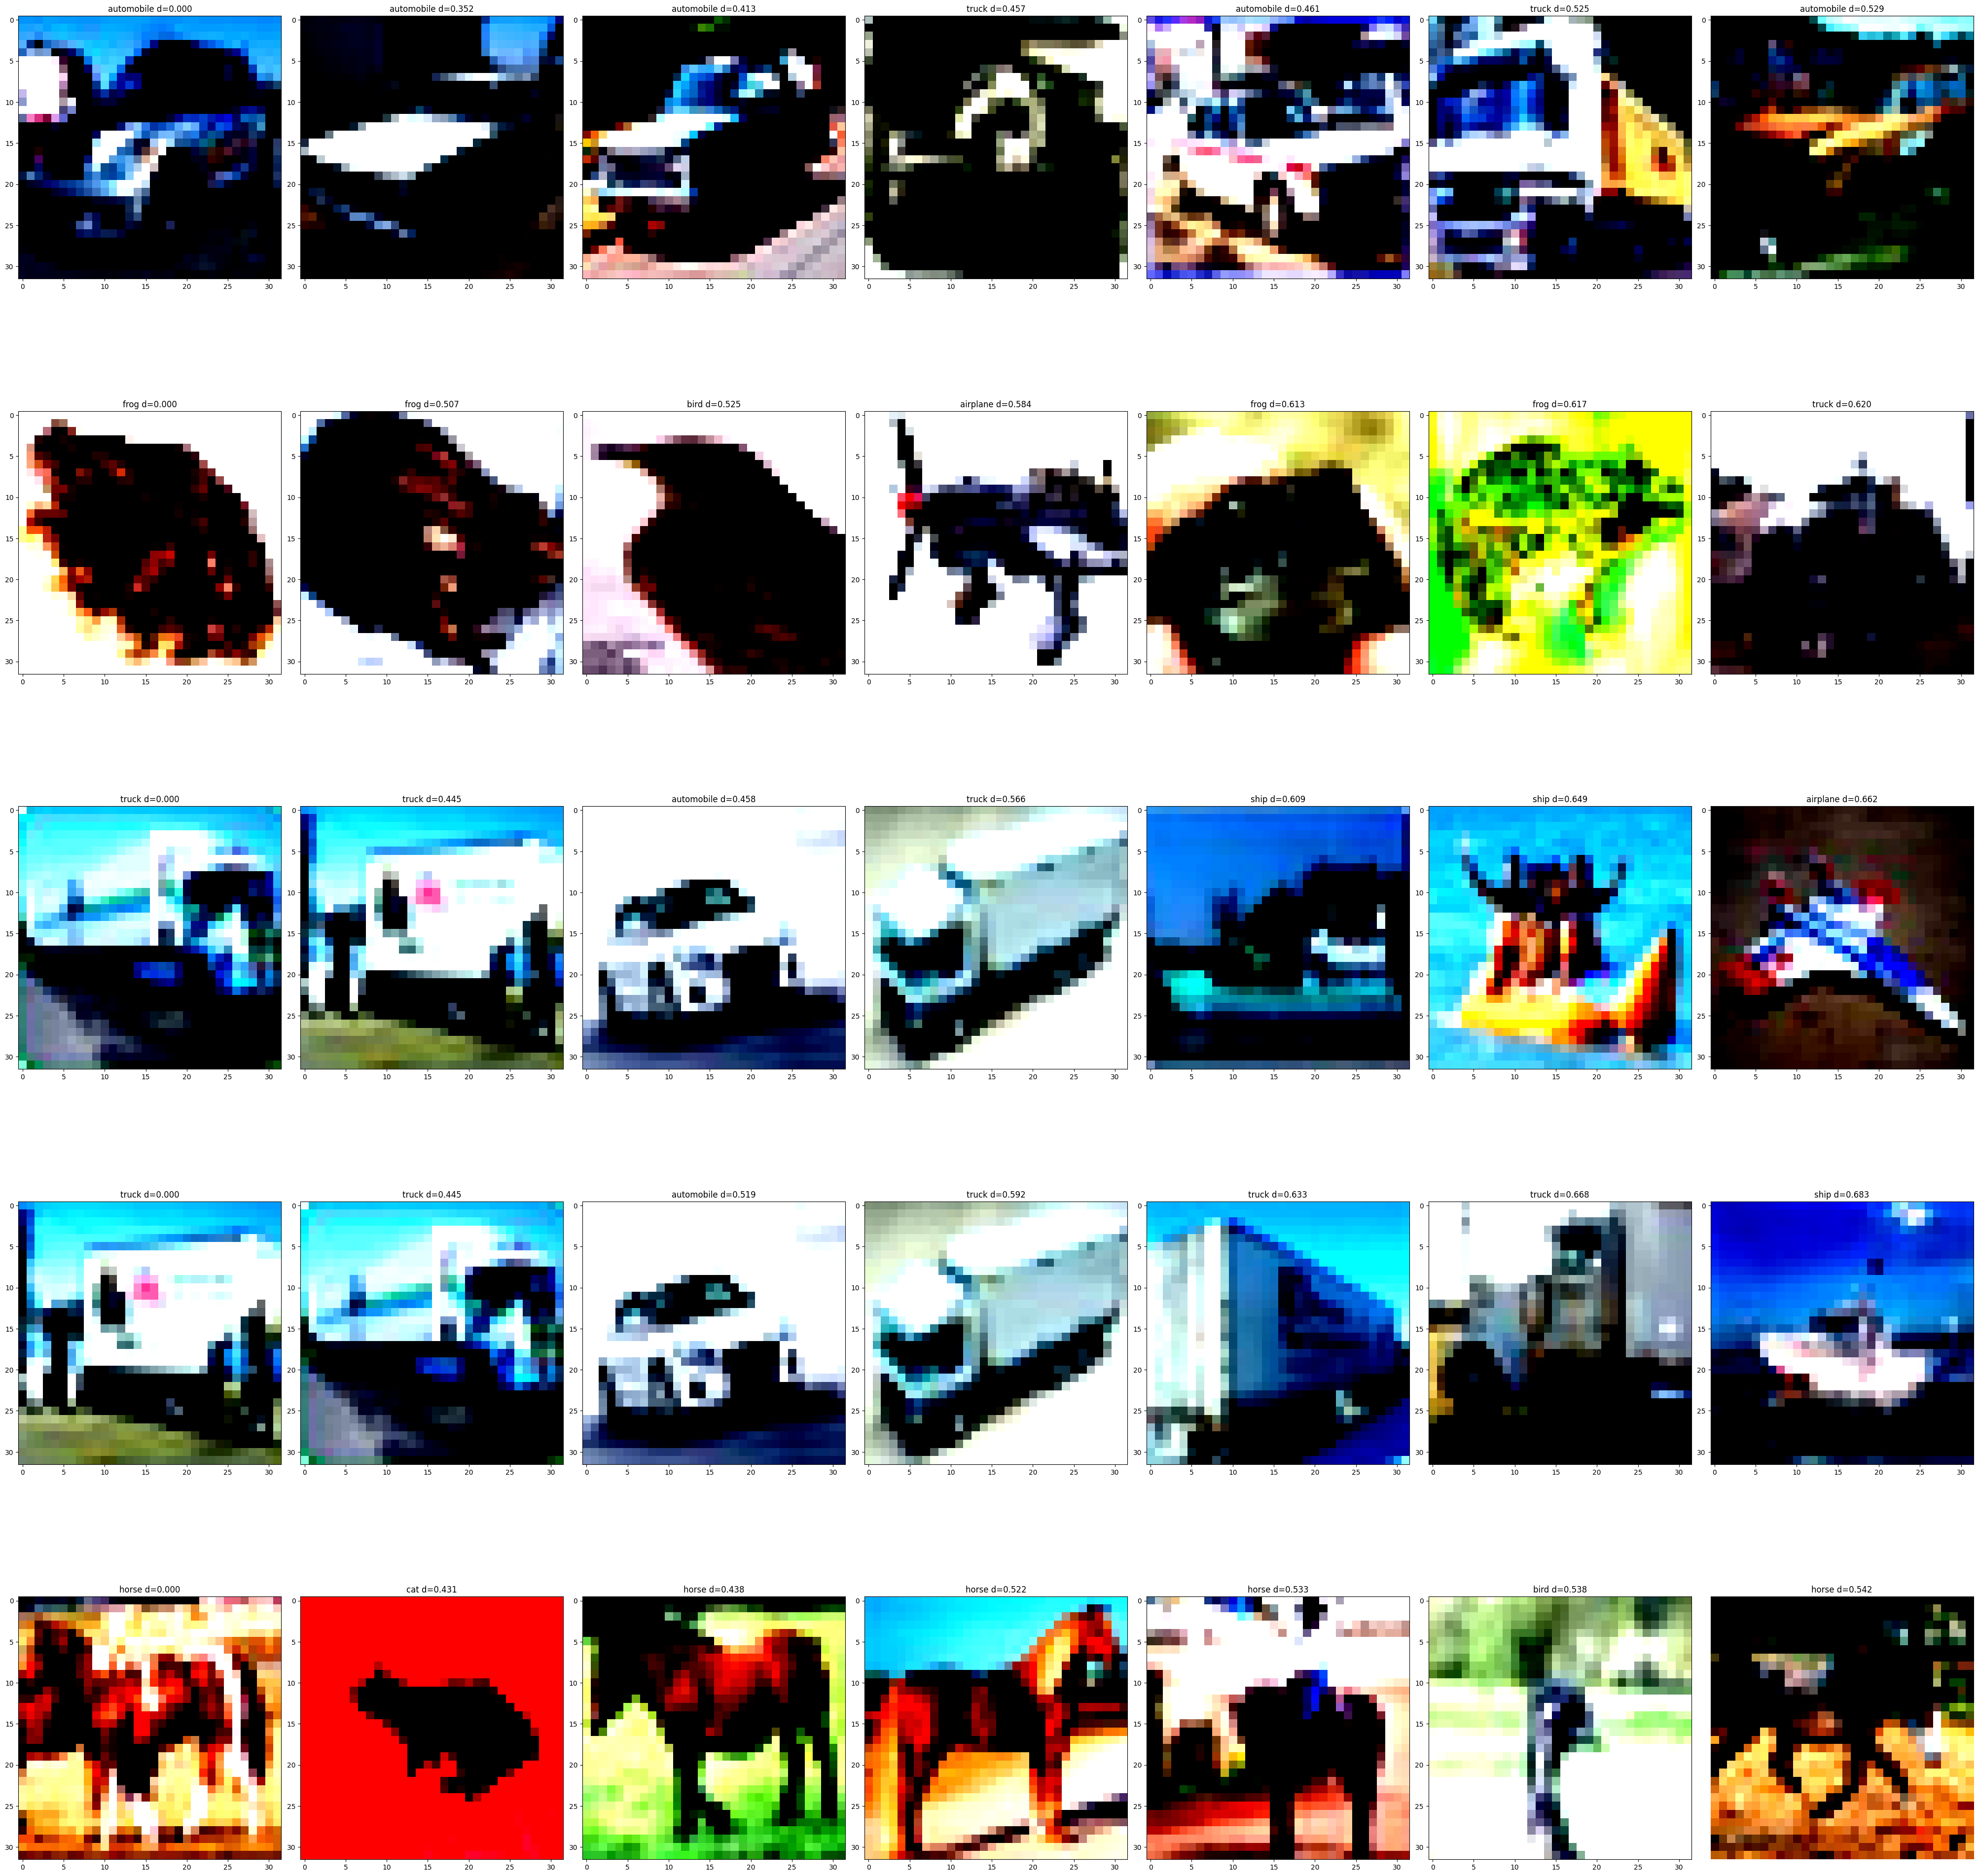

In [64]:
plot_knn_examples(embeddings, filenames, labels, num_examples=5, n_neighbors=7)

#Save backbone model

In [66]:
torch.save(backbone.state_dict(), 'model_cifar_10_SimCLR38.23.pt')